In [27]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101);

## Models in Pyro 

* The basic unit of Pyro programs is the *stochastic function*. A *stochastic function* consits of two parts:
    * A deterministic python code
    * primitive stochastic function
* A stochastic function can be any python object with `__call__()` like a function, method or Pytorch `nn.Module()`. 
* Stochastic fucntions can be seen as models as they used to represent simplified or abstract descriptions of a process by which data are generated. 


## Primitive Stochastic Functions

* Use **Pytorch's** disctribution library.
* Can create custom distributions using **transforms**

### Drawing sample from unit Normal 

In [28]:
loc = 0.   # mean zero
scale = 1. # unit variance

In [29]:
normal = dist.Normal(loc, scale) # create a normal distribution object

In [30]:
x = normal.sample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-1.3905)
log prob tensor(-1.8857)


* Parameters passed to the `dist.Normal` are `torch.Tensors` so to be able to make use of **Pytorchs** autograd capabiltites duruing inference.

### Sampling 

In [31]:
x = pyro.sample("my_sample", dist.Normal(loc, scale))
print(x)

tensor(-0.8152)


* Sample is named
* Pyro’s backend uses these names to uniquely identify sample statements

## Simple Model 

Let’s suppose we have a bunch of data with daily mean temperatures and cloud cover. We want to reason about how temperature interacts with whether it was sunny or cloudy. A simple stochastic function that does that is given by:

In [32]:
def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 72.30651092529297)
('sunny', 91.11004638671875)
('sunny', 92.53456115722656)


In [33]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', dist.Normal(expected_sales, 10.0))
    return ice_cream

In [34]:
ice_cream_sales()

tensor(205.6327)

## Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow 

* Since pyro is embedded in python, stochastic functions can be arbitrarily complex and randomness can freely affect the control flow.
* Example, a recursive function whose termination is non-deterministic
 * Shown below is a gemoetric series that counts number of failure until first success.

In [42]:
def geometric(p, t=None):
    if t is None:
        t = 0
        
    ######### Make sure unique sample names are passed
    x = pyro.sample("x_{}".format(t), dist.Bernoulli(p)) 
    
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

print(geometric(0.001))

186


* Stochastic functions that accept as input or produce as output other stochastic functions:

In [44]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z2 = pyro.sample("z2", dist.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(3.))

tensor(1.5278)


# Inference 

* You have an object of which you want to measure the weight
* You have a weighing machine with is unreliable

In [11]:
def scale(guess):
    #var = pyro.sample("var", dist.Normal(guess, 1.0))
    var = 1
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.Normal(guess, var))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

* Suppose we want to get an estimate of the object weight using this model
* This involves marginializing over **guess** and then sampling
* Marginialization in Pyro is done using `pyro.infer.EmpericalMarginal`
    * First collect a number of weighted exection traces of the model
    * Collapse traces into histogram of possible return values

In [12]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [13]:
guess = 8.5

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(10.3621)


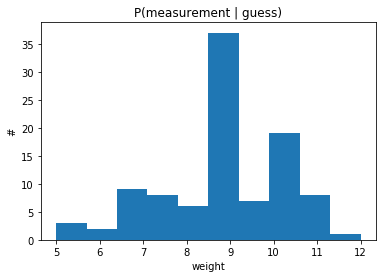

In [14]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#");

# Conditioning on Data (Observe)

* Given observed data we want to infer the latent factors that could have generated it
* `pyro.condition` allows to constrain the value of sample statements

In [15]:
# Takes as input
# 1. Model
# 2. Dictionary containing the observed values
conditioned_scale = pyro.condition(
    scale, data={"measurement": 9.5})
# returns a new model 
# Has same input and output signatures but always uses the given values at observed sample statements

In [16]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

### Passing observed value directly to sample statement

In [17]:
# `obs` keyword is reserved for this purpose
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we attach an observation measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.),
                       obs=9.5)

* Hardcoding is not recomended due to non-compositional nature
* 

In [18]:
def scale2(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0., 1.)))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))

# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.2}),
    data={"measurement": 9.5})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": 9.5}),
    data={"weight": 9.2})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": 9.2, "measurement": 9.5})

In [19]:
# CAUSAL INFRENCE ??

## Flexible Approximate Inference With Guide Functions 

tensor(9.3092)


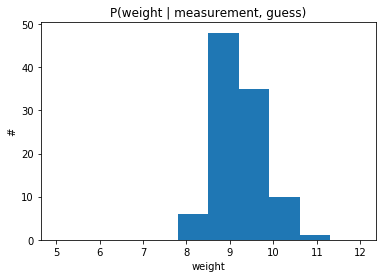

In [20]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")
# When site is specified marginal will compute the marginal distribution of that site, 
#rather than of the return value

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

* The above set up is inefficient because the prior distribution over `weigths` may be very far from true distribution depending on the intial value of `guess`
* Pryo supports arbitrary stochastic functions, guide function/guides, as approximate posterior dist

In [47]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.Normal(guess, 1.))

posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

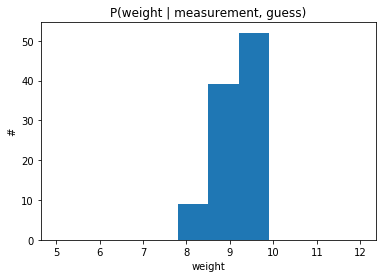

In [49]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Variational Inference 

* in general it is intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function
* `pyro.param` can be used to specify a family of guides indexed by named parameters and search for the member of that family that is the best approximation
* We can use `pyro.param` to parametrize `a` and `b` instead of specifying them by hand

In [22]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

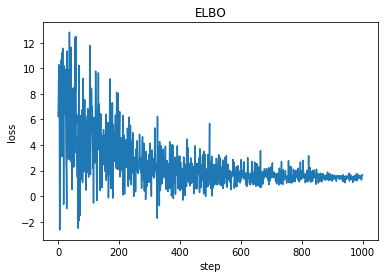

In [23]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

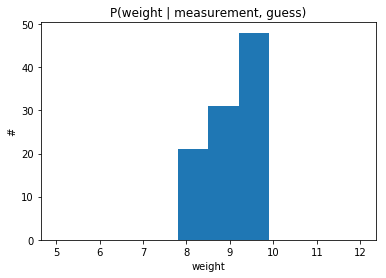

In [25]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

* We can also sample from the guide directly as an approximate posterior:

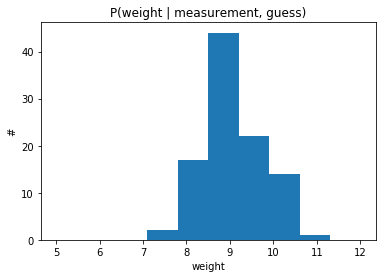

In [26]:
plt.hist([scale_parametrized_guide(guess).item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");